# Part 1: Imports and setup

In [ ]:
# =========================================
# Imports
# =========================================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import joblib


# Part 2: Load data and extract labels

In [85]:
# 1) Load data
df = pd.read_csv(
    "/Users/sehriban/Desktop/Row_Data_Mouse/DE_results/Groups/cancer_tissue/ML_ready_expression_matrix_cancer_tissue.csv",
    dtype={"sample_id": str},
    low_memory=False
)

# 2) Extract label
df["label"] = df["sample_id"].str.split(".").str[1]

# 3) Keep only Epi / Mes
df = df[df["label"].isin(["Epi", "Mes"])]

# 4) Define X and y
X = df.drop(columns=["sample_id", "label"])
y = df["label"]

print("Original shape:", X.shape, y.shape)

Original shape: (45, 22045) (45,)


# Part3: Handle NA / Inf

In [86]:
# Keep only numeric columns
X_num = X.select_dtypes(include=[np.number])

# Replace infinite values with NaN
X_num.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop columns with all NaNs
X_num = X_num.dropna(axis=1, how="all")

# Impute remaining NaNs with median
imputer = SimpleImputer(strategy="median")
X_clean = pd.DataFrame(imputer.fit_transform(X_num), columns=X_num.columns, index=X_num.index)

print("After cleaning, shape:", X_clean.shape)

After cleaning, shape: (45, 22045)


# Part 4: Select top 1000 most variable genes

In [91]:
variances = X_clean.var(axis=0)
top_genes_idx = np.argsort(variances)[-2000:]
X_top = X_clean.iloc[:, top_genes_idx]

print("Top 1000 genes shape:", X_top.shape)

Top 1000 genes shape: (45, 2000)


# Part 5: Train-test split

In [92]:
X_train, X_test, y_train, y_test = train_test_split(
    X_top, y, test_size=0.3, stratify=y, random_state=42
)

# Optional: check class balance
print("Class distribution:\n", y.value_counts())


Class distribution:
 Epi    24
Mes    21
Name: label, dtype: int64


# Block 6: Define models

In [93]:
models = {
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "SVM": SVC(kernel="rbf", probability=True, random_state=42),
    "NeuralNet": MLPClassifier(hidden_layer_sizes=(128, 64),
                               activation="relu", solver="adam",
                               max_iter=500, random_state=42)
}

# Part 7: Train, evaluate, save models

In [94]:
from sklearn.metrics import roc_auc_score, roc_curve, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import joblib

for name, model in models.items():
    print(f"\n=== Training {name} ===")
    
    # Pipeline: scaling + model
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        (name, model)
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    # Classification report
    report = classification_report(y_test, y_pred, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    report_df.to_csv(f"{name}_classification_report.csv")
    print(report_df)
    
    # Confusion matrix
    disp = ConfusionMatrixDisplay.from_estimator(pipeline, X_test, y_test, cmap="Blues")
    plt.title(f"{name} - Confusion Matrix")
    
    # Calculate AUC
    if hasattr(model, "predict_proba"):
        y_proba = pipeline.predict_proba(X_test)[:, 1]  # Probability for positive class
    elif hasattr(model, "decision_function"):
        y_proba = pipeline.decision_function(X_test)
    else:
        y_proba = None
    
    if y_proba is not None:
        auc = roc_auc_score(y_test, y_proba)
        plt.text(0.5, -0.1, f"AUC = {auc:.3f}", ha="center", fontsize=12, transform=plt.gca().transAxes)
        print(f"{name} AUC: {auc:.3f}")
    
    plt.savefig(f"{name}_confusion_matrix.png")
    plt.close()
    
    # Save trained model
    joblib.dump(pipeline, f"{name}_model.pkl")



=== Training RandomForest ===
              precision    recall  f1-score    support
Epi            0.555556  0.714286  0.625000   7.000000
Mes            0.600000  0.428571  0.500000   7.000000
accuracy       0.571429  0.571429  0.571429   0.571429
macro avg      0.577778  0.571429  0.562500  14.000000
weighted avg   0.577778  0.571429  0.562500  14.000000
RandomForest AUC: 0.837

=== Training SVM ===
              precision    recall  f1-score    support
Epi            0.583333  1.000000  0.736842   7.000000
Mes            1.000000  0.285714  0.444444   7.000000
accuracy       0.642857  0.642857  0.642857   0.642857
macro avg      0.791667  0.642857  0.590643  14.000000
weighted avg   0.791667  0.642857  0.590643  14.000000
SVM AUC: 0.816

=== Training NeuralNet ===
              precision    recall  f1-score    support
Epi            0.555556  0.714286  0.625000   7.000000
Mes            0.600000  0.428571  0.500000   7.000000
accuracy       0.571429  0.571429  0.571429   0.571429


# Part 8: Feature importance

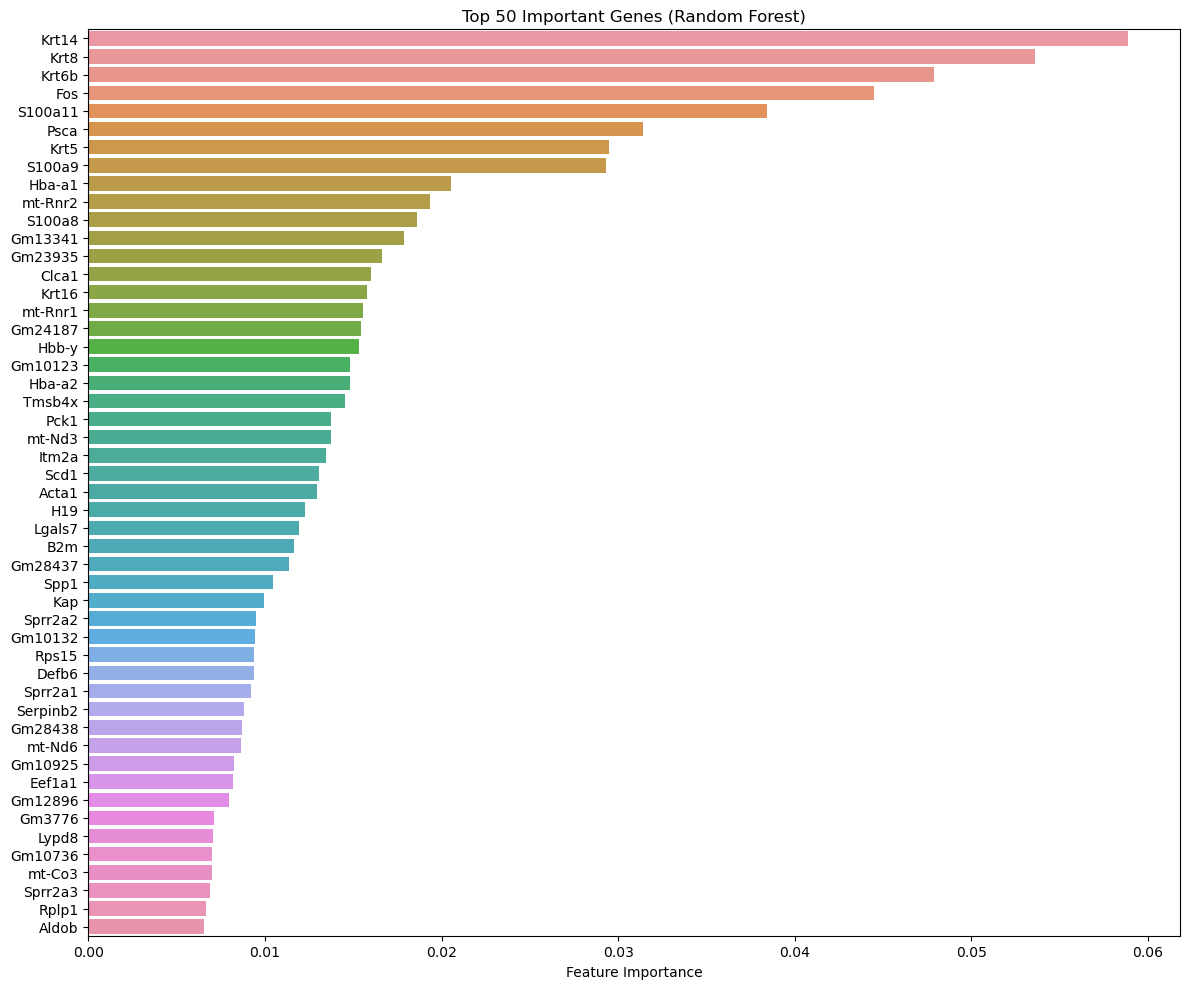

In [73]:
rf_model = models["RandomForest"] ## Seleck which model do you wanna see
rf_model.fit(X_train, y_train)

# Get feature importances
importances = rf_model.feature_importances_
feat_importances = pd.Series(importances, index=X_top.columns).sort_values(ascending=False)

# Save all genes
feat_importances.to_csv("/Users/sehriban/Desktop/Row_Data_Mouse/DE_results/Groups/normal_tissue/RandomForest_all_gene_importances.csv", header=True)

# Save top 50 important genes
top_50 = feat_importances.head(50)
top_50.to_csv("top_50_important_genes.csv", header=True)

# Plot top 50
plt.figure(figsize=(12, 10))
sns.barplot(x=top_50.values, y=top_50.index)
plt.title("Top 50 Important Genes (Random Forest)")
plt.xlabel("Feature Importance")
plt.tight_layout()
plt.savefig("top_50_important_genes.png")
plt.show()

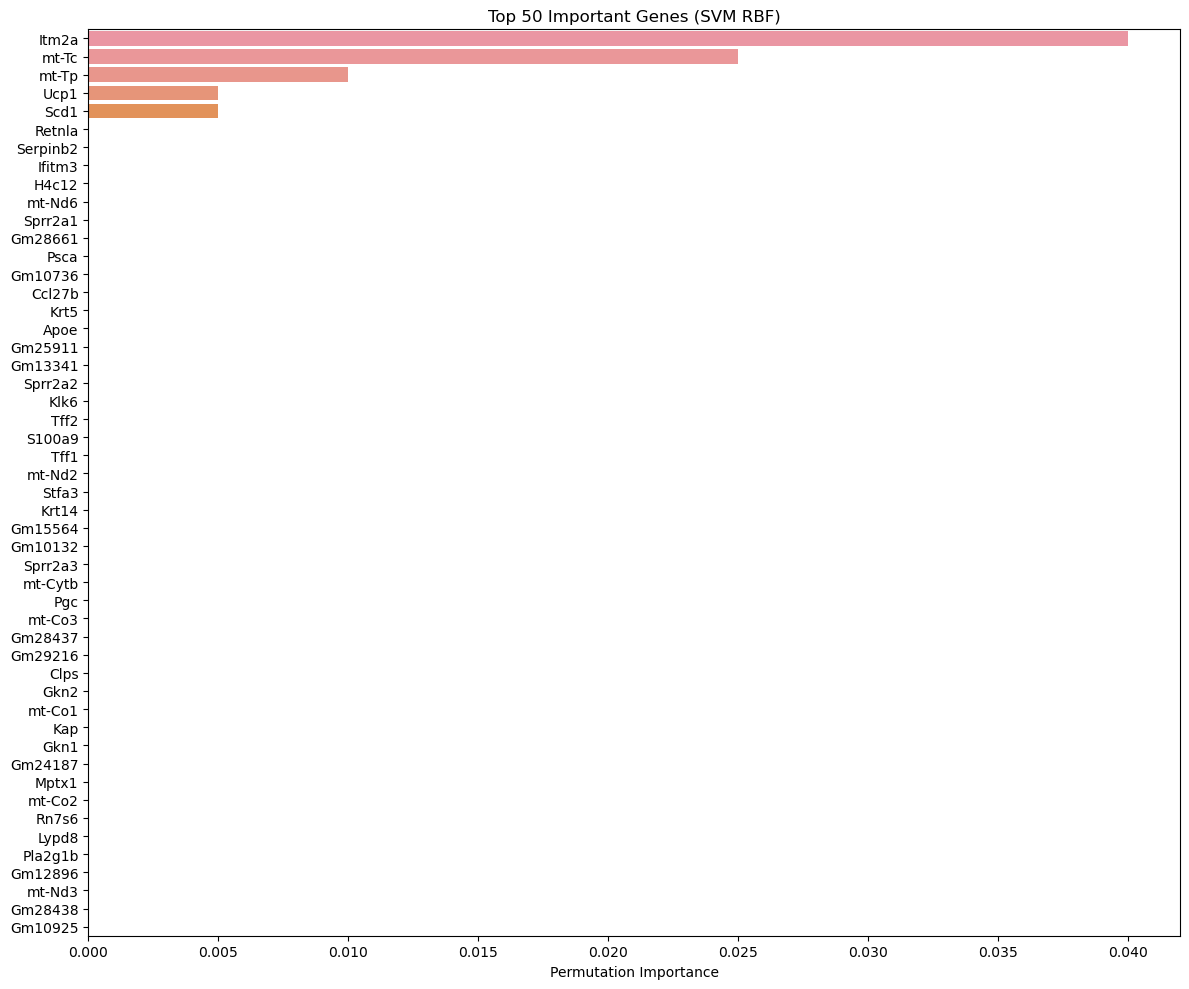

In [74]:
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit SVM (RBF)
svm_model = models["SVM"]
svm_model.fit(X_train_scaled, y_train)

# Permutation importance
svm_result = permutation_importance(svm_model, X_test_scaled, y_test, n_repeats=10, random_state=42)
svm_importances = pd.Series(svm_result.importances_mean, index=X_top.columns).sort_values(ascending=False)

# Save all gene importances
svm_importances.to_csv("/Users/sehriban/Desktop/Row_Data_Mouse/DE_results/Groups/normal_tissue/SVM_RBF_feature_importances.csv", header=True)

# Plot top 50 genes
top_50_svm = svm_importances.head(50)
plt.figure(figsize=(12, 10))
sns.barplot(x=top_50_svm.values, y=top_50_svm.index)
plt.title("Top 50 Important Genes (SVM RBF)")
plt.xlabel("Permutation Importance")
plt.tight_layout()
plt.savefig("SVM_RBF_top_50_genes.png")
plt.show()


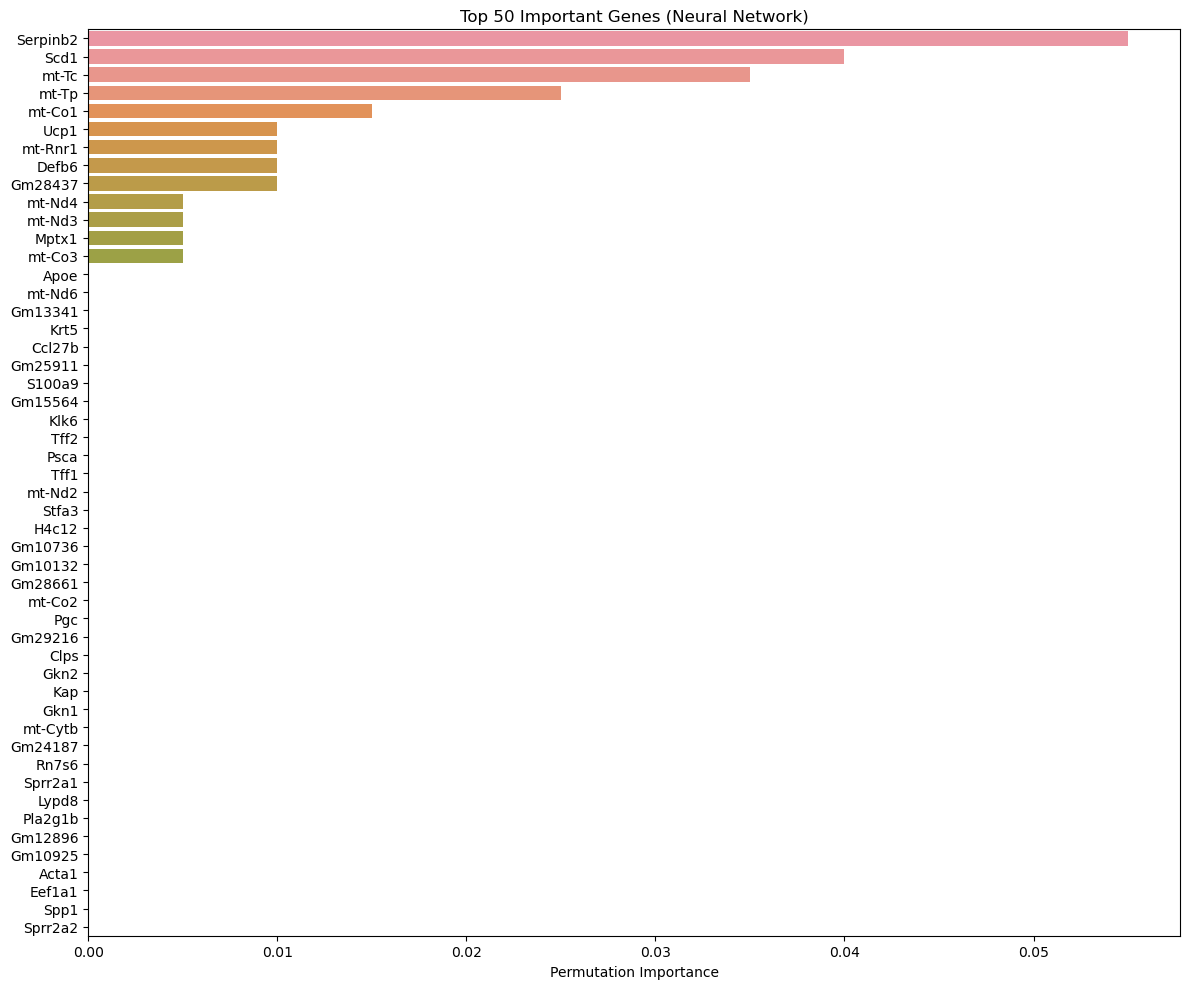

In [75]:
# Fit Neural Network
nn_model = models["NeuralNet"]
nn_model.fit(X_train_scaled, y_train)

# Permutation importance
nn_result = permutation_importance(nn_model, X_test_scaled, y_test, n_repeats=10, random_state=42)
nn_importances = pd.Series(nn_result.importances_mean, index=X_top.columns).sort_values(ascending=False)

# Save all gene importances
nn_importances.to_csv("/Users/sehriban/Desktop/Row_Data_Mouse/DE_results/Groups/normal_tissue/NN_feature_importances.csv", header=True)

# Plot top 50 genes
top_50_nn = nn_importances.head(50)
plt.figure(figsize=(12, 10))
sns.barplot(x=top_50_nn.values, y=top_50_nn.index)
plt.title("Top 50 Important Genes (Neural Network)")
plt.xlabel("Permutation Importance")
plt.tight_layout()
plt.savefig("NN_top_50_genes.png")
plt.show()